### Trabalho Final da Matéria de Processamento de Imagens - BCC FURB

<b>Turma:</b> SUP-CMP.187.0.2-2024/1<br>
<b>Docente:</b> Aurélio Faustino Hoppe<br>
<b>Discentes:</b> Arthur B Pinotti, Kaue Reblin, Luiz G Klitzke<br>

In [25]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
# Parâmetros

img_height, img_width = 256, 256
path_dataset = "Images"
labels_classes = ["Habitado", "NaoHabitado"]

In [29]:
#Obtem os datasets de treino e validação através da estrutura de pastas

train_dataset, validation_dataset  = keras.utils.image_dataset_from_directory(
    path_dataset,
    labels = "inferred",
    label_mode = "int",
    class_names = labels_classes,
    color_mode = "rgb",
    batch_size = 32,
    image_size = (img_height, img_width),
    shuffle = True,
    validation_split = 0.2, #Usa n% de dados para validação
    subset = "both",
    verbose =  True,
    seed = 1024,
)

Found 486 files belonging to 2 classes.
Using 389 files for training.
Using 97 files for validation.


In [30]:
# Construção do modelo CNN

cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn.summary()

c:\Users\luizk\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,086,913 (49.92 MB)

 Trainable params: 13,086,913 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compilação do modelo
cnn.compile(
    loss='sparse_categorical_crossentropy', #https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function
    optimizer='sgd', #https://keras.io/api/optimizers/sgd/
    metrics=['accuracy']
)

# Treinamento do modelo
history_cnn = cnn.fit(
    train_dataset,
    epochs = 5,
    validation_data = validation_dataset,
)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 876ms/step - accuracy: 0.5563 - loss: 16185536872491941550559854592.0000 - val_accuracy: 0.6495 - val_loss: 0.6899
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 807ms/step - accuracy: 0.6682 - loss: 0.6885 - val_accuracy: 0.6495 - val_loss: 0.6864
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 814ms/step - accuracy: 0.7000 - loss: 0.6830 - val_accuracy: 0.6495 - val_loss: 0.6831
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 864ms/step - accuracy: 0.6856 - loss: 0.6795 - val_accuracy: 0.6495 - val_loss: 0.6801
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 811ms/step - accuracy: 0.7052 - loss: 0.6741 - val_accuracy: 0.6495 - val_loss: 0.6775


In [32]:
# Avaliação do modelo
loss, accuracy = cnn.evaluate(validation_dataset, verbose = 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6285 - loss: 0.6799


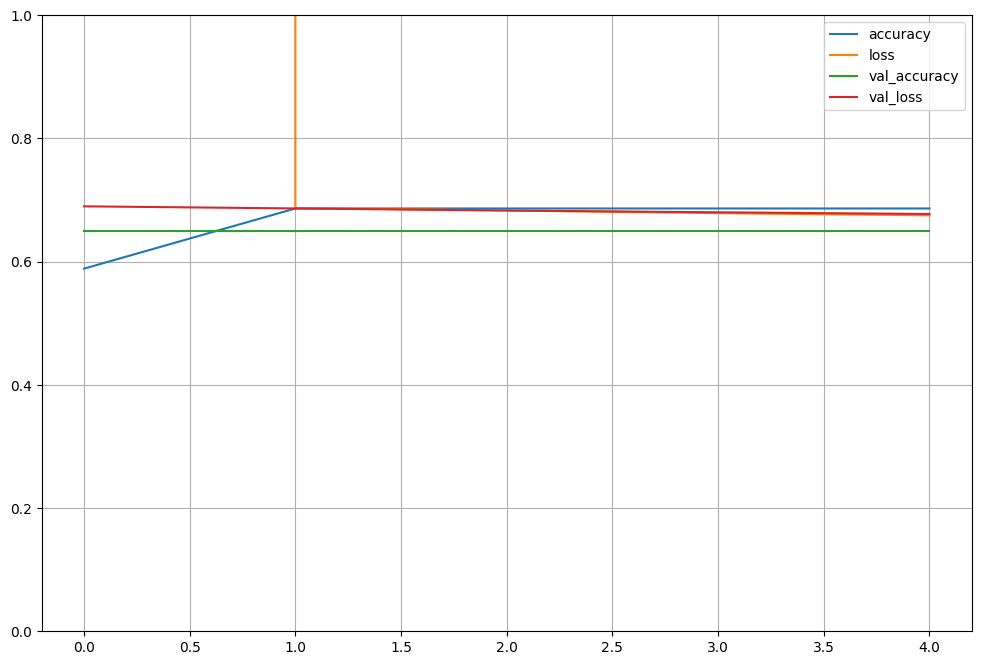

In [33]:
#Apresenta os dados da performânce do algoritmo, atráves do membro history, preenchido com a execução.
pd.DataFrame(history_cnn.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()